# Photonic Quantum Reservoir with Quantum Memristor

This notebook contains the implementation and the reproduction of the methods and results presented in the following paper:
- Title: Experimental neuromorphic computing based on quantum memristor (2025)
- Authors: Mirela Selimovic, Iris Agresti, Michal Siemaszko, Joshua Morris, Borivoje Dakic, Riccardo Albiero, Andrea Crespi, Francesco Ceccarelli, Roberto Osellame, Magdalena Stobinska, and Philip Walther
- DOI/ArXiv: https://arxiv.org/pdf/2504.18694

## Contribution

The main goal of the paper is to demonstrate the advantages of using a Quantum Memristor in a Photonic Quantum Reservoir architecture in order to enhance its performance in prediction tasks. The authors propose a setup which they also implement and test experimentally.

The main advantage of using this Quantum Memristor framework is that it enhances the impact of the non-linear measurements of the photonic quantum circuit, allowing us to achieve higher performance in tasks where non-linearity is advantageous (most of the time series datasets belong to this category).

## Repository structure 

The purpose of this notebook is to briefly explain the results from the original paper and the reproduction. It does not contain all the details regarding the code used. Most of the code is imported from python files that exist in the repository:

- `lib/training.py`: functions required for the training and the evaluation of the models used.
- `lib/quantum_reservoir.py`: all the types of photonic quantum reservoir models implemented using Merlin.
- `lib/feedback.py`: neural network that acts as the quantum memristor.
- `lib/classical_models.py`: implementation of the classical models used for comparison.

## Quantum memristor: circuit architecture

The photonic quantum setup (circuit and feedback loop for the memristor) that authors propose in this paper is described in the following figure. The memristor updates the parameters of a specific phase shifter based on the probabilties of measuring the photon in the last mode of the quantum circuit.

![alt text](utils/images/circuit.png)

We can build this circuit using Perceval (Quandela's library for computing and manipulating photonic quantum computers).

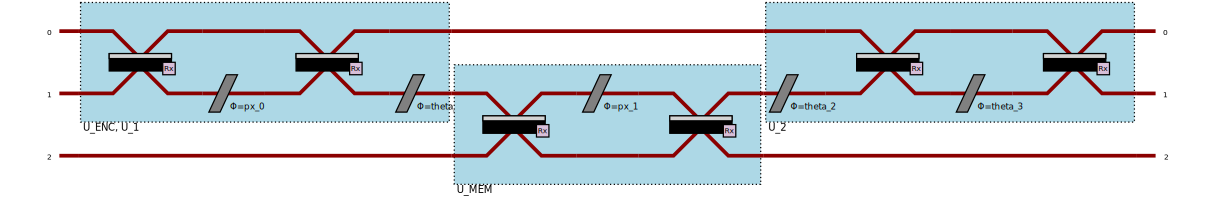

In [1]:
import perceval as pcvl
import perceval.components as comp

phi_enc = pcvl.P(f"px_{0}")
# First MZI that contains the encoding of the data and U_1
u_enc_u_1 = (pcvl.Circuit(2, name="U_enc, U_1")
             .add((0, 1), comp.BS())
             .add(1, comp.PS(phi=phi_enc))
             .add((0, 1), comp.BS())
             .add(1, comp.PS(phi=pcvl.P(f"theta_{1}"))))

# Memory/feedback circuit with feedback input (px_1)
u_mem = (pcvl.Circuit(2, name="U_mem")
         .add((0, 1), comp.BS())
         .add(0, comp.PS(phi=pcvl.P(f"px_{1}")))  # FEEDBACK INPUT
         .add((0, 1), comp.BS()))

# Measurement circuit
u_2 = (pcvl.Circuit(2, name="U_2")
       .add(1, comp.PS(phi=pcvl.P(f"theta_{2}")))
       .add((0, 1), comp.BS())
       .add(1, comp.PS(phi=pcvl.P(f"theta_{3}")))
       .add((0, 1), comp.BS()))

quantum_circ = pcvl.Circuit(3)
quantum_circ.add(0, u_enc_u_1)
quantum_circ.add(1, u_mem)
quantum_circ.add(0, u_2)

pcvl.pdisplay(quantum_circ, recursive=True)

### Implementation of the entire network using Merlin

We can implement the whole framework using Merlin. It contains two main components:

1. Photonic quantum layer
2. Feedback layer which acts as the quantum memristor

For more information regarding the code used for the quantum reservoir and the feedback layer you can check the files `lib/quantum_reservoir.py` and `lib/feedback.py` respectively.

In [2]:
import merlin as ml
from lib.feedback import FeedbackLayer, FeedbackLayerNARMA

input_dim = 1
memory = 4  # defines the memory size that we want to use (we can choose whatever value we want)

quantum_layer = ml.QuantumLayer(
    input_size=input_dim + 1,  # the feedback acts as an input for the implementation
    circuit=quantum_circ,
    trainable_parameters=["theta"],
    input_parameters=["px"],
    input_state=[0, 1, 0],
    measurement_strategy=ml.MeasurementStrategy.PROBABILITIES,
    no_bunching=True
)

feedback = FeedbackLayer(memory_size=memory)

## Use-cases for the quantum reservoir with quantum memristor

In the paper the authors choose two main tasks in order to evaluate the performance of their framework and also to compare it with some baseline classical methods (for more information regarding the datasets used, check [the paper](https://arxiv.org/pdf/2504.18694)).

1. Nonlinear function prediction
2. Time series datasets (mainly NARMA)

In [3]:
import sys
import os
import pandas as pd

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import Tasks
from lib.run_quantum import run_nonlinear_task, run_narma_task

# Import Plotting Functions (from your attached file)
from utils.create_plots import *

# Import Notebook Helpers (from the new file)
from utils.notebook_utils import NotebookArgs, run_experiment, run_classical_benchmarks

### Nonlinear function prediction

The specific task is quite simple, and it is about the prediction of the power function $f_{t}(x) = x^{n}$ (with $n = 4$ in our case). It is a task which not very difficult to implement and at the same time it seems ideal to demonstrate the advantages of using a quantum memristor as the in order to achieve accurate prediction performance we have to enhance the nonlinearity effect of our model.

We can run the experiment using the following code and also pring the resulting plot which is identical to *Figure 3* in the paper. 

In [4]:
# Run Baseline (No Memristor)
args_nomem = NotebookArgs(task="nonlinear", model_type="nomem", memory=4, epochs=100, lr=0.01)
res_nomem = run_experiment(args_nomem, run_nonlinear_task)

# Run Experiment (Memristor)
args_mem = NotebookArgs(task="nonlinear", model_type="memristor", memory=4, epochs=100, lr=0.01)
res_mem = run_experiment(args_mem, run_nonlinear_task)

--- Starting Experiment: nomem on nonlinear ---


Training Run 10: 100%|██████████| 100/100 [00:03<00:00, 26.15it/s]


--- Starting Experiment: memristor on nonlinear ---


Training Run 10: 100%|██████████| 100/100 [00:05<00:00, 17.00it/s]


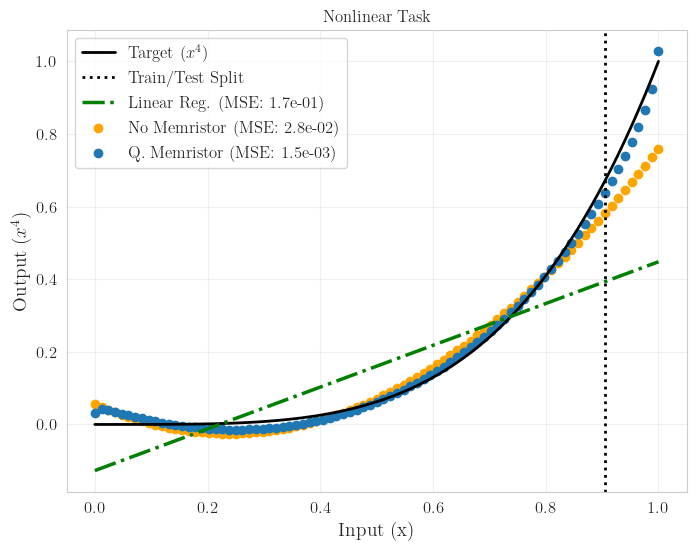

In [5]:
# Plot the figure that compares all the models
plot_nonlinear_notebook(res_mem, res_nomem)

### Time series prediction (NARMA)

Another task which can be used to clearly demonstrate the advantages of using the quantum memristor is the prediction of the NARMA function. The goal of this task is to predict the output of the following non-linear dynamics:

<center>$y_{t+1} = 0.4y_{t} + 0.4y_{t}y_{t−1} + 0.6x_{t}^{3} + 0.1$</center>

We can run the photonic quantum reservoir with the quantum memristor and the classical baselines for the NARMA task using the code below.

In [6]:
# Run Experiment
args_narma = NotebookArgs(task="narma", model_type="memristor", memory=4)
res_narma = run_experiment(args_narma, run_narma_task)

# Print Mean MSE
print("-" * 30)
print(f"Quantum NARMA Result (over {args_narma.n_runs} runs):")
print(f"Mean MSE: {res_narma['mean_mse']:.6f}")
print(f"Std  MSE: {res_narma['std_mse']:.6f}")
print("-" * 30)

--- Starting Experiment: memristor on narma ---
Train MSE: 0.000024
Test  MSE: 0.000029
Run 01/10 — test MSE = 0.000029
Train MSE: 0.000022
Test  MSE: 0.000027
Run 02/10 — test MSE = 0.000027
Train MSE: 0.000031
Test  MSE: 0.000025
Run 03/10 — test MSE = 0.000025
Train MSE: 0.000024
Test  MSE: 0.000030
Run 04/10 — test MSE = 0.000030
Train MSE: 0.000032
Test  MSE: 0.000026
Run 05/10 — test MSE = 0.000026
Train MSE: 0.000024
Test  MSE: 0.000026
Run 06/10 — test MSE = 0.000026
Train MSE: 0.000026
Test  MSE: 0.000025
Run 07/10 — test MSE = 0.000025
Train MSE: 0.000025
Test  MSE: 0.000036
Run 08/10 — test MSE = 0.000036
Train MSE: 0.000030
Test  MSE: 0.000027
Run 09/10 — test MSE = 0.000027
Train MSE: 0.000030
Test  MSE: 0.000027
Run 10/10 — test MSE = 0.000027

=== NARMA results ===
Runs: 10
Mean test MSE: 0.000028
Std  test MSE: 0.000003
------------------------------
Quantum NARMA Result (over 10 runs):
Mean MSE: 0.000028
Std  MSE: 0.000003
------------------------------


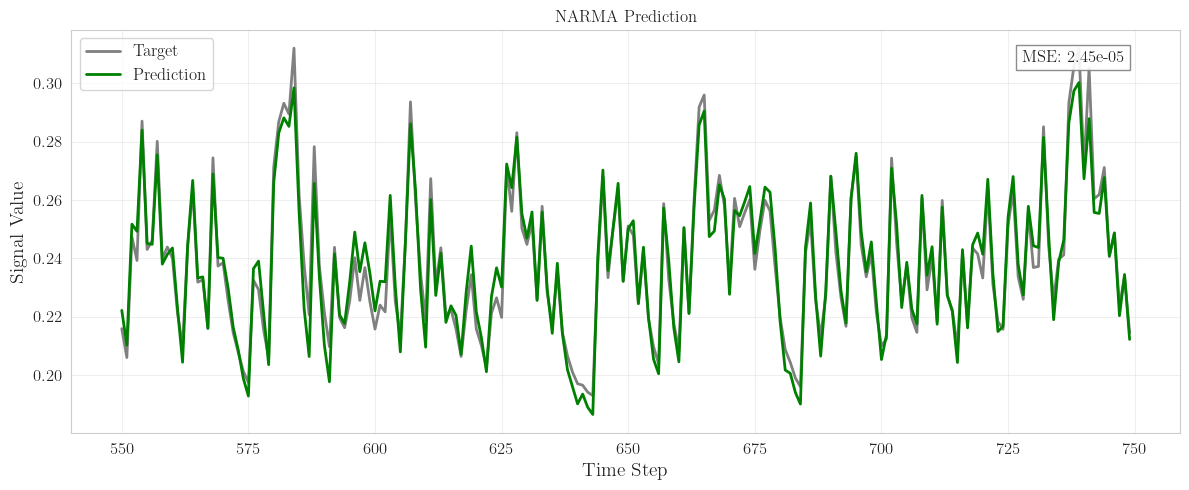

In [7]:
plot_narma_notebook(res_narma)

In [8]:
# Run classical baseline models defined in the paper (automatically loops through L, Q, L+M, Q+M models)
args_narma_classical = NotebookArgs(task="narma", model_type="memristor", memory=4, epochs=200, lr=0.1)
classical_results = run_classical_benchmarks(args_narma)

In [10]:
final_results = classical_results.copy()

final_results["Q. Mem"] = {
    "mean": res_narma["mean_mse"],
    "std":  res_narma["std_mse"]
}

print("\n=== Comparative Analysis: Classical vs Quantum ===")
df_compare = pd.DataFrame(final_results).T
df_compare.columns = ["Mean MSE", "Std Dev"]

save_path = "./results/final_comparison.json"
df_compare.to_json(save_path, orient="index", indent=4)

display(df_compare)


=== Comparative Analysis: Classical vs Quantum ===


,Mean MSE,Std Dev
L,0.000287,0.000039
Q,0.000242,0.000040
L+M,0.000175,0.000019
Q+M,0.000108,0.000039
Q. Mem,0.000028,0.000003
